In [1]:
import numpy as np
import matplotlib.pyplot as plt
from bosonStar import *
from util import *

from ctypes import *
file = "./testing.so"
my_func = CDLL(file)

#Middle
massInCU = 2e-77
aInCU = 1e-73
totalMassInCU = 0.1
dtInCU = 2500.0
bigT = 20000

/home/kklee/anaconda3/lib/python3.11/site-packages/scipy/integrate/_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


A2=  -0.3197640202007044  X= 20.65212130424261
A2=  -0.4847073570486533  X= 20.0997201994404
A2=  -0.49962370647516496  X= 40.0
A2=  -0.5019378672698831  X= 16.740033480066963
A2=  -0.5018381151222431  X= 21.703563407126815
A2=  -0.501873065422044  X= 15.347950695901392
A2=  -0.5019294650803621  X= 13.257546515093031
A2=  -0.5019294650803621  X= 13.257546515093031
MU= 0.31816194102760903 MASS= 0.09999058237901089
FAR POINT: 164264 500000


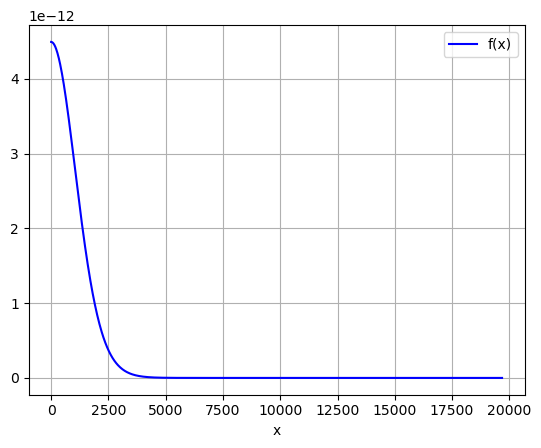

(750,)


In [2]:
allThings = outputProfile(massInCU, aInCU, totalMassInCU, 500)
#Hot Fix
x = allThings["x"][1::2]
psi = allThings["profile"][1::2]

dx = x[1]-x[0]
for i in range(500):
    x = np.append(x, x[-1]+dx)
    psi = np.append(psi, psi[-1])

print(x.shape)

In [3]:
totalMass = massSIToPlanckUnit(massCodeUnitToSI(totalMassInCU))
m = massSIToPlanckUnit(massCodeUnitToSI(massInCU))
a = lengthSIToPlanckUnit(lengthCodeUnitToSI(aInCU))
N = totalMass/m
Ra = np.sqrt(a/m/m/m)
omegaA = m*m/np.abs(a)
epsilon = 1.0/omegaA/m/Ra/Ra
a0 = np.sqrt(1.0/omegaA/m)
delta = 4.0*np.pi*a*N/a0
GM = totalMass/Ra/Ra/Ra/omegaA/omegaA

print("R:", Ra)
print("Omega:" ,omegaA)
print("Epsilon (Should be 1):", epsilon)
print("Delta:", delta)
print("New G:", GM)

R: 3.8684718785837514e+40
Omega: 3.656129092998465e-43
Epsilon (Should be 1): 1.0000000000000002
Delta: 14.839459489461666
New G: 1.180886665279879


In [4]:
x = lengthSIToPlanckUnit(lengthCodeUnitToSI(x))/Ra
x = np.concatenate((np.flip(-x), x))

psi = np.sqrt(densitySIToPlanckUnit(densityCodeUnitToSI(psi))/totalMass)*np.power(Ra, 3.0/2.0)
psi = np.concatenate((np.flip(psi), psi))
normalization = np.trapz(2.0*np.pi*x*x*np.absolute(psi)*np.absolute(psi), x)
psi = psi/normalization
psi = psi.astype(complex)

'''
for index, value in enumerate(psi):
    if(value<1e-8):
        psi[index] = 0
psi = psi.astype(complex)
'''

size = len(psi)
dt = timeSIToPlanckUnit(timeCodeUnitToSI(dtInCU))*omegaA
dx = x[1]-x[0]

print(psi)
print(dt)

[0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]
0.08351027137908527


In [5]:
T = np.zeros((size,size)).astype(complex)
TSph = np.zeros((size,size)).astype(complex)
Q = np.zeros((size,size)).astype(complex)
V2Grav = np.zeros((size,size)).astype(complex)
I = np.identity(size).astype(complex)
phi = np.zeros((size))

In [6]:
def setupT():
    global T, TSph
    for i in range(size):
        if i==0:
            T[i][i] = -5.0/2.0 + 4.0/3.0 - 1.0/12.0
            T[i][i+1] = 4.0/3.0
            T[i][i+2] = -1.0/12.0
            TSph[i][i+1] = 1.0/2.0/x[i]
            TSph[i][i] = -1.0/2.0/x[i]
        elif i==1:
            T[i][i-1] = 4.0/3.0 -1.0/12.0
            T[i][i] = -5.0/2.0
            T[i][i+1] = 4.0/3.0
            T[i][i+2] = -1.0/12.0
            TSph[i][i+1] = 1.0/2.0/x[i]
            TSph[i][i-1] = -1.0/2.0/x[i]
        elif i==size-2:
            T[i][i-2] = -1.0/12.0
            T[i][i-1] = 4.0/3.0
            T[i][i] = -5.0/2.0
            T[i][i+1] = 4.0/3.0 - 1.0/12.0
            TSph[i][i+1] = 1.0/2.0/x[i]
            TSph[i][i-1] = -1.0/2.0/x[i]
        elif i==size-1:
            T[i][i-2] = -1.0/12.0
            T[i][i-1] = 4.0/3.0
            T[i][i] = -5.0/2.0 + 4.0/3.0 -1.0/12.0
            TSph[i][i-1] = -1.0/2.0/x[i]
            TSph[i][i] = 1.0/2.0/x[i]
        else:
            T[i][i-2] = -1.0/12.0
            T[i][i-1] = 4.0/3.0
            T[i][i] = -5.0/2.0
            T[i][i+1] = 4.0/3.0
            T[i][i+2] = -1.0/12.0
            TSph[i][i+1] = 1.0/2.0/x[i]
            TSph[i][i-1] = -1.0/2.0/x[i]

    T = -1.0/2.0/dx/dx*T
    TSph = -1.0/dx*TSph

def setupQ():
    global Q
    for i in range(size):
        Q[i][i] = delta*np.absolute(psi[i])*np.absolute(psi[i])

def setupV2Grav():
    global V2Grav, phi, psi

    rho = np.absolute(psi)[size//2:]*np.absolute(psi)[size//2:]
    rho_c = (c_double * size)(*rho)
    phi_c = (c_double * size)(*np.absolute(phi)[size//2:])
    my_func.findGravRho(rho_c, phi_c, c_int(size//2), c_double(dx))
    for i in range(size//2):
        place = int(size//2 + i)
        phi[place] = phi_c[i] * GM

    for i in range(size//2):
        V2Grav[i][i] = phi[size-i-1]
        V2Grav[size-i-1][size-i-1] = phi[size-i-1]
            
        phi[i] = phi[size-i-1] #Regulate

def setupU1U2():
    global U1, U2
    U1 = I + 1.0j*dt/2.0*(T+TSph+Q+V2Grav)
    U2 = I - 1.0j*dt/2.0*(T+TSph+Q+V2Grav)

0 0.0 0.05835838670151642 1.000079033520485
1 0.08351027137908527 0.05836368908112551 1.0000790302037545
2 0.16702054275817055 0.058363907522338276 1.0000790148671674
3 0.2505308141372558 0.058365274192503855 1.0000789947745417
4 0.3340410855163411 0.058367865277676165 1.0000789699518333
5 0.4175513568954264 0.05837020846064195 1.0000789386744524
6 0.5010616282745116 0.05837383380265669 1.000078902716066
7 0.5845718996535969 0.0583780027302629 1.0000788612014808
8 0.6680821710326822 0.05838281220795283 1.0000788142483803
9 0.7515924424117675 0.05838861929463234 1.0000787622770597
10 0.8351027137908528 0.05839495183501757 1.0000787047472133
11 0.9186129851699381 0.058402189710838694 1.0000786421216303
12 1.0021232565490232 0.05841015414009538 1.000078574212645
13 1.0856335279281086 0.05841880449100928 1.0000785010021989
14 1.1691437993071938 0.058428306741489744 1.000078422717752
15 1.2526540706862792 0.0584384331136915 1.0000783391310077
16 1.3361643420653644 0.05844934442905473 1.0000

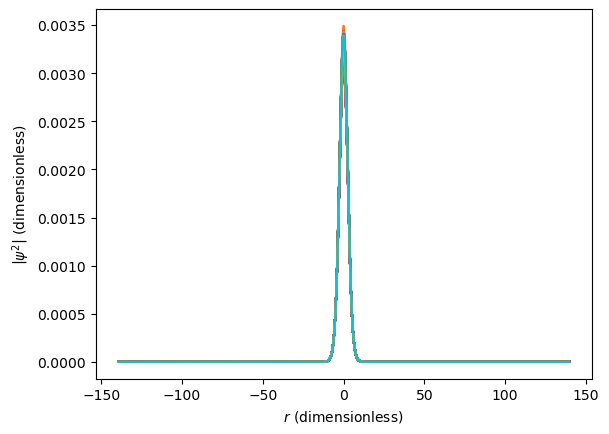

In [7]:
setupT()
setupQ()
setupV2Grav()
setupU1U2()


#Record
gravitationalForce = []
pressureGradient = []
quantumPressure = []

hello = []
ts = []
oldGM = GM
newGM = GM*1.1
for t in range(bigT):
    #Pertubation
    if(t*dt<3.0):
        GM = newGM
    if(t*dt>=3.0):
        GM = oldGM

    setupQ()
    setupV2Grav()
    setupU1U2()
    psi = np.linalg.solve(U2, np.dot(U1,psi))

    #Regulate
    for i in range(size//2):
        psi[i] = psi[size-i-1]

    normalization = np.trapz(2.0*np.pi*x*x*np.absolute(psi)*np.absolute(psi), x)
    if(normalization >= 1.01):
        break
    print(t, t*dt, np.absolute(psi[size//2]), normalization)
    if(GM == oldGM):
        hello.append(np.absolute(psi[size//2])*np.absolute(psi[size//2]))
        ts.append(t*dt)

        #Record
        rho0 = (np.absolute(psi[size//2 + 14])*np.absolute(psi[size//2 + 14]))/Ra/Ra/Ra*totalMass
        rho1 = (np.absolute(psi[size//2 + 15])*np.absolute(psi[size//2 + 15]))/Ra/Ra/Ra*totalMass
        rho2 = (np.absolute(psi[size//2 + 16])*np.absolute(psi[size//2 + 16]))/Ra/Ra/Ra*totalMass
        rho3 = (np.absolute(psi[size//2 + 17])*np.absolute(psi[size//2 + 17]))/Ra/Ra/Ra*totalMass
        Q0 = -((np.sqrt(rho0) -2*np.sqrt(rho1) + np.sqrt(rho2))/(dx*Ra)/(dx*Ra) + 2.0/(x[size//2 + 15]*Ra)*(np.sqrt(rho1)-np.sqrt(rho0))/(dx*Ra))/np.sqrt(rho1)/2.0/m
        Q1 = -((np.sqrt(rho1) -2*np.sqrt(rho2) + np.sqrt(rho3))/(dx*Ra)/(dx*Ra) + 2.0/(x[size//2 + 16]*Ra)*(np.sqrt(rho2)-np.sqrt(rho1))/(dx*Ra))/np.sqrt(rho2)/2.0/m

        gravitationalForce.append((phi[size//2 + 16]-phi[size//2 + 15])/dx)
        pressureGradient.append(4.0*np.pi*a/m/m/m*(rho2-rho1)/(dx*Ra)/Ra/omegaA/omegaA)
        quantumPressure.append((Q1-Q0)/m/(dx*Ra)/Ra/omegaA/omegaA)

    if t%100 == 0:
        plt.plot(x, np.absolute(psi)*np.absolute(psi))

plt.xlabel(r"$r$ (dimensionless)")
plt.ylabel(r"$\left | \psi^2 \right |$ (dimensionless)")
plt.show()

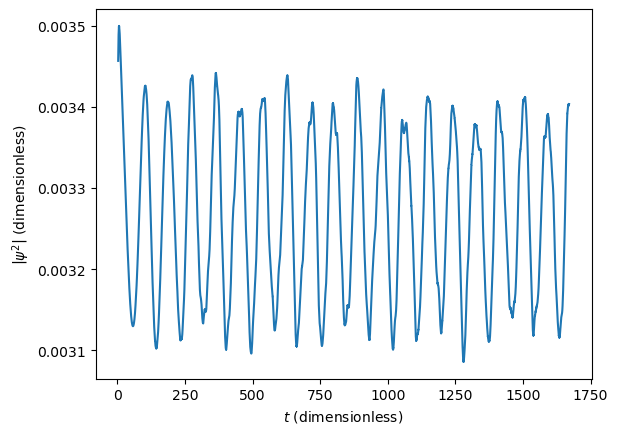

In [8]:
plt.plot(ts, hello)
plt.xlabel(r"$t$ (dimensionless)")
plt.ylabel(r"$\left | \psi^2 \right |$ (dimensionless)")
plt.show()

Text(0.5, 0, 'f (1/s)')

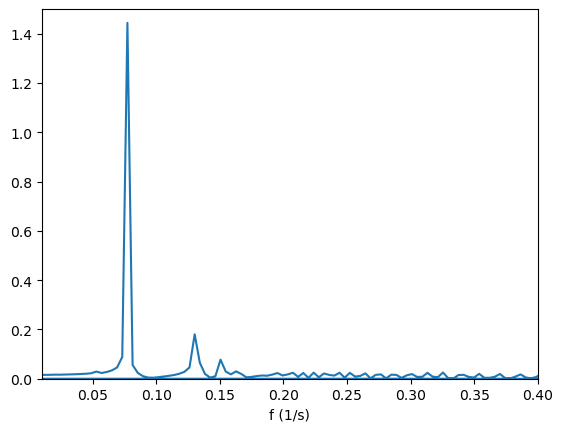

In [9]:
sp = np.fft.fft(hello)
freq = np.fft.fftfreq(len(hello), d=dt)*omegaA/5.391247e-44

plt.plot(freq, np.absolute(sp))
plt.xlim(0.01,0.4)
plt.ylim(0.0,1.5)
plt.xlabel("f (1/s)")

In [10]:
print(freq[1]-freq[0])
for i in range(len(freq)-1):
    if(freq[i] > 0.0 and np.absolute(sp[i]) > 0.07 and np.absolute(sp[i])>np.absolute(sp[i+1]) and np.absolute(sp[i])>np.absolute(sp[i-1])):
        print(freq[i], np.absolute(sp[i]))

0.004067661791224204
0.07728557403325986 1.4441575340145183
0.13016517731917454 0.18008948523168916
0.15050348627529556 0.0774814463494775


[3.93637241e-07 3.81368073e-07 3.87319574e-07 ... 3.87319574e-07
 3.81368073e-07 3.93637241e-07]


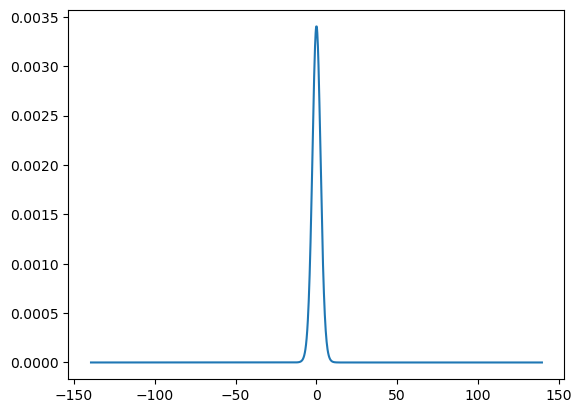

In [11]:
plt.plot(x, np.absolute(psi)*np.absolute(psi))
print(np.absolute(psi))

Middle
0.071-0.081			M1 (M2: 0.142-0.162, M3: 0.213-0.243, M4: 0.284-0.324, M5: 0.355-0.405)
0.132-0.137			M1?
0.158-0.163			M2
0.193-0.204			M1?
0.239-0.249			M3
0.295-0.305			M4
0.361-0.371			M5

0.076-0.086			M1
0.132-0.142			M1?
0.158-0.168			M2

Small
0.097-0.107		M1
0.163-0.173		M1?
0.214-0.224		M2
0.270-0.280		M1?
0.341-0.351		M3
0.432-0.443		M4
0.534-0.544		M5
0.651-0.661		M6

Heavy
0.031-0.037		M1
0.058-0.065		M2
0.072-0.078		M?
0.082-0.089		M?
0.099-0.167 	M3
0.116-0.123		M4
0.140-0.147		M5
0.167-0.173		M6?
0.194-0.201 	M7?

In [12]:
print(psi)

[-8.27346263e-08-3.84844461e-07j -1.06921402e-07-3.66072972e-07j
 -1.23321407e-07-3.67162475e-07j ... -1.23321407e-07-3.67162475e-07j
 -1.06921402e-07-3.66072972e-07j -8.27346263e-08-3.84844461e-07j]


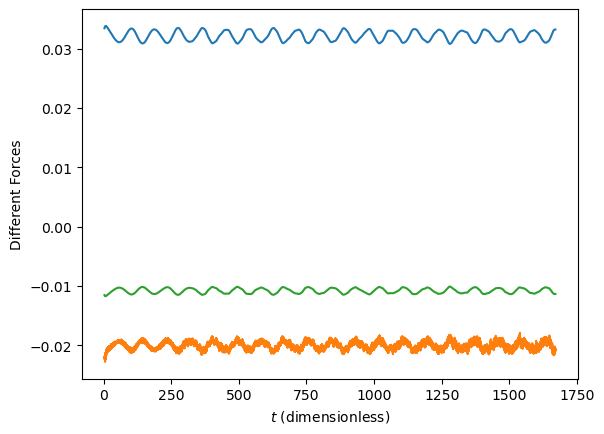

In [13]:
plt.plot(ts, gravitationalForce)
plt.plot(ts, quantumPressure)
plt.plot(ts, pressureGradient)
plt.xlabel(r"$t$ (dimensionless)")
plt.ylabel(r"Different Forces")
plt.show()